[tensorflow example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [2]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [3]:
data_dir = '../data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [4]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file
    zip_path = os.path.join(words_data, 'words.zip')
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    # Return a list of all the words in the data source
    return data.decode('ascii').split()

In [5]:
words = fetch_words_data()

In [6]:
len(words), type(words)

(17005207, list)

In [8]:
words[:6]

['anarchism', 'originated', 'as', 'a', 'term', 'of']

In [9]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [10]:
from collections import Counter

In [52]:
my_list = ['one','two','two']
Counter(my_list), Counter(my_list).most_common(2)

(Counter({'one': 1, 'two': 2}), [('two', 2), ('one', 1)])

In [13]:
def create_counts(vocab_size=50000):
    
    vocab = []+Counter(words).most_common(vocab_size) # collect the most common words and freq
    
    vocab = np.array([word for word,_ in vocab]) # only collect the words without freq
    
    dictionary = {word:code for code,word in enumerate(vocab)} # convert words to indices
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data,vocab

In [14]:
data,vocabulary = create_counts()

In [15]:
vocabulary.shape, words[100], data[100]

((50000,), 'interpretations', 4186)

In [36]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    span = 2*skip_window + 1 # [skip_window target skip_window]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i*num_skips + j] = buffer[skip_window]
            labels[i*num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


In [17]:
# CONSTANTS

In [18]:
batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2

In [19]:
valid_size = 16

In [22]:
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)

In [23]:
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50000

In [24]:
tf.reset_default_graph()
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [25]:
init_embeds = tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0)

In [26]:
embeddings = tf.Variable(init_embeds)

In [27]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

In [28]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/np.sqrt(embedding_size)))

In [29]:
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [30]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights,nce_biases,train_labels,embed,num_sampled,vocabulary_size))

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)

In [32]:
trainer = optimizer.minimize(loss)

In [33]:
# Compute the cosine similarity between minibatch examples and all
# embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                          valid_dataset)
similarity = tf.matmul(
    valid_embeddings, normalized_embeddings, transpose_b=True)

In [34]:
data_index = 0

In [35]:
init = tf.global_variables_initializer()

In [39]:
num_steps = 500
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {
            train_inputs:batch_inputs,
            train_labels:batch_labels
        }
        
        _,loss_val = sess.run([trainer,loss],feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step%100 == 0:
            if step>0:
                average_loss = average_loss/100
            print("Average Loss at step {} is: {}".format(
                step,
                average_loss
            ))
            average_loss = 0
        final_embeddings = normalized_embeddings.eval()

Average Loss at step 0 is: 276.6298828125
Average Loss at step 100 is: 1204.344965362549
Average Loss at step 200 is: 3322.8259060668947
Average Loss at step 300 is: 6141.110266418457
Average Loss at step 400 is: 9269.00409790039


In [40]:
final_embeddings.shape

(50000, 150)

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)

In [42]:
plot_only=500
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [43]:
labels = [vocabulary[i] for i in range(plot_only)]


In [44]:
low_dim_embed[:3]

array([[11.88677  ,  4.2810965],
       [15.670057 ,  4.188324 ],
       [12.653974 ,  2.7001994]], dtype=float32)

In [45]:
low_dim_embed.shape

(500, 2)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0]>=len(labels), "More labels than embeddings"
    plt.figure(figsize=(18,18)) # in inches
    for i,label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(
            label,
            xy=(x,y),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()

/anaconda3/envs/deeplearning/lib/python3.7/site-packages/matplotlib/text.py:2178: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


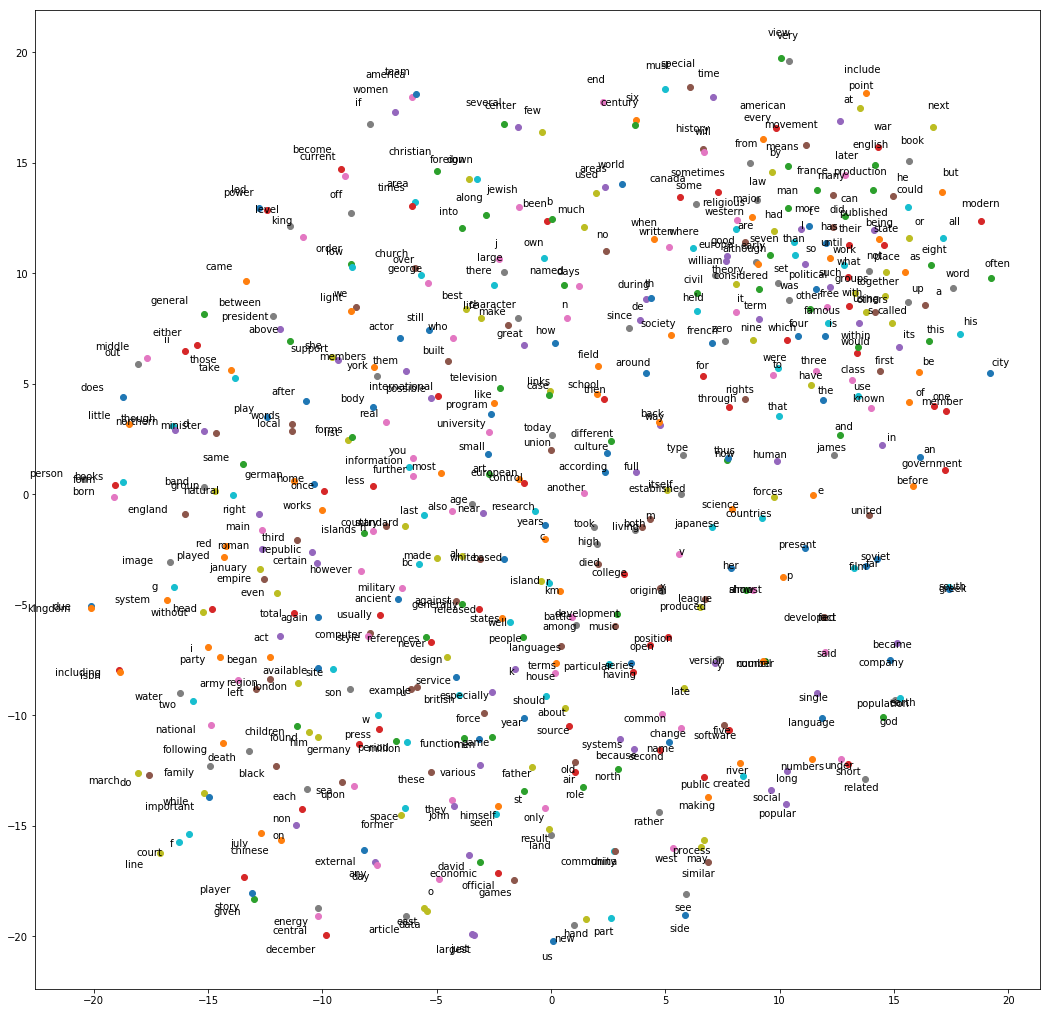

In [49]:
plot_with_labels(low_dim_embed,labels)

In [50]:
final_embeddings = np.load('trained_embeddings_200k_steps.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'trained_embeddings_200k_steps.npy'